<a href="https://colab.research.google.com/github/BryanMed/Sequences-Time-Series-and-Prediction/blob/master/Semana2DNNforecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep neural networks para predecir series temporales

Pues este es el final de la semana 2 del curso, en el que en lugar de usar una sola capa (y neurona) para realizar una regresión lineal de los datos, usaremos una arquitectura más complejas (DNN) con una capa oculta.

In [0]:
!pip install tf-nightly-2.0-preview

In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

print(tf.__version__)

2.0.0-dev20191002


Lo de siempre, las funciones para mostrar y generar las series de datos, además de los argumentos con los cuales dividiremos al dataset en ventanas

In [0]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

def trend(time, slope=0):
    return slope * time

def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

time = np.arange(4 * 365 + 1, dtype="float32")
baseline = 10
series = trend(time, 0.1)  
baseline = 10
amplitude = 40
slope = 0.05
noise_level = 5

# Create the series
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)
# Update with noise
series += noise(time, noise_level, seed=42)

split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

En la función de *windowed_dataset* se dividirá la serie temporal en ventanas, y se barajeará

In [0]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
  dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
  dataset = dataset.batch(batch_size).prefetch(1)
  return dataset

Aquí generaremos el modelo de nuestra DNN (la entrada será el tamaño de la ventana), y contará con dos capas ocultas (10, 10), para finalmente terminar con una capa de salida de 1 neurona.

In [7]:
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Dense(10, input_shape=[window_size], activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1)
])

model.compile(loss='mse', optimizer=tf.keras.optimizers.SGD(lr=1e-6, momentum=0.9))
model.fit(dataset, epochs=100, verbose=0)

Realizamos la predicción

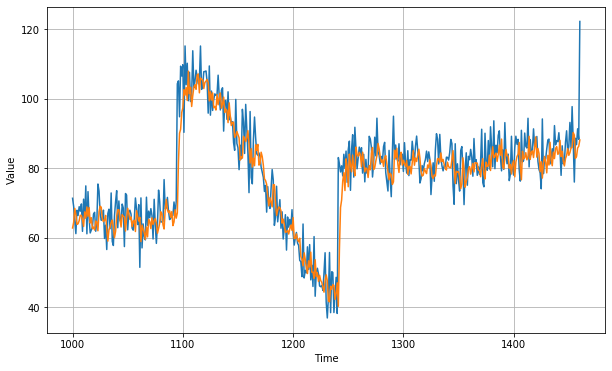

In [8]:
forecast = []
for time in range(len(series) - window_size):
  forecast.append(model.predict(series[time:time+window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]

plt.figure(figsize=(10,6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

No es muy diferente (mejor) esta predicción respecto a los métodos estadísticos anteriores, y esto es debido a que no estamos utilizando los parámetros óptimos, como bien sería el learning rate.

In [11]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

5.051834

Así que veremos un método para obtener un buen learning rate, utilizando callbacks de este parámetro

In [0]:
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Dense(10, input_shape=[window_size], activation='relu'),                                    
  tf.keras.layers.Dense(10, activation='relu'),
  tf.keras.layers.Dense(1)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch:1e-8 * 10**(epoch / 20))

optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss='mse', optimizer=optimizer)
history = model.fit(dataset, epochs=100, callbacks=[lr_schedule], verbose=0)

En este bloque veremos una gráfica de lr (eje x) vs error (eje y), y el lr que estamos buscando es aquel en el cual tenemos un error bajo, pero que también se encuentra estable (por eso de los $8 e^{-3}$)

[1e-08, 0.001, 0, 300]

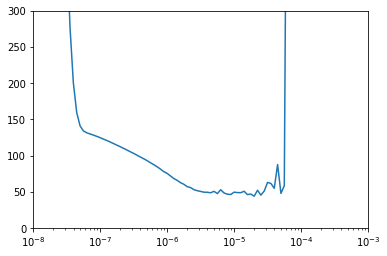

In [10]:
lrs = 1e-8 * (10 ** (np.arange(100) / 20))
plt.semilogx(lrs, history.history['loss'])
plt.axis([1e-8, 1e-3, 0, 300])

Ahora si, entrenaremos utilizando ese learning rate.

In [0]:
window_size = 30
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Dense(10, activation="relu", input_shape=[window_size]),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1)
])

optimizer = tf.keras.optimizers.SGD(lr=8e-6, momentum=0.9)
model.compile(loss="mse", optimizer=optimizer)
history = model.fit(dataset, epochs=500, verbose=0)

Esta vez graficamos el errors, pero como que esa caída tan grande de error en los primeros valores no permite apreciar si el error continua bajando o nel.

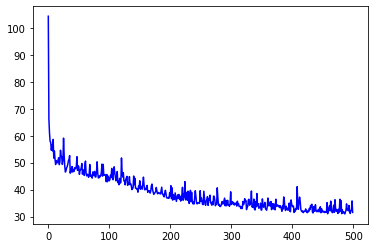

In [20]:
loss = history.history['loss']
epochs = range(len(loss))
plt.plot(epochs, loss, 'b', label='Training Loss')
plt.show()


Así que para que podamos a preciar bien los valores, quitemos los 10 primero valores alv

[54.313957623353936, 51.34083277908797, 49.29517853727046, 50.79061743352831, 50.094797480475044, 49.97375590530867, 50.886780744729585, 51.85210030545893, 49.27086515918221, 50.21432794885537, 54.59051530975656, 52.599652115340085, 52.088153988553074, 49.334688391144745, 50.755111580288286, 59.09586041637303, 52.84771653008215, 48.64770959283888, 46.52194769947799, 46.97464046674905, 48.06520263042646, 48.54465031574682, 49.404377345448914, 50.71285177801073, 51.285079012212066, 52.61719346980459, 46.09488977648548, 47.60356690711582, 46.563113694338455, 48.55386528723019, 46.536150808432666, 47.337225609218955, 46.710234872090446, 48.09881085071367, 47.75203314712367, 47.708215646645456, 48.77530383080551, 52.204222893469115, 47.10398589458662, 48.8301784318747, 48.50250728253237, 45.64666293429345, 47.066114170035135, 47.34104238293835, 48.03098672296583, 49.67172286043462, 45.730439892011816, 47.3410066034376, 46.67714867346066, 45.27283633517236, 49.3686329320534, 50.5730040402756

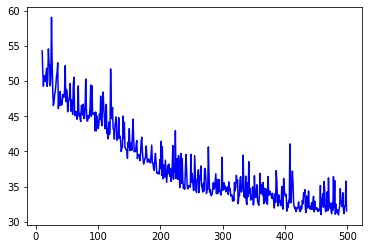

In [16]:
loss = history.history['loss']
epochs = range(10, len(loss))
plot_loss = loss[10:]
print(plot_loss)
plt.plot(epochs, plot_loss, 'b', label='Training Loss')
plt.show()

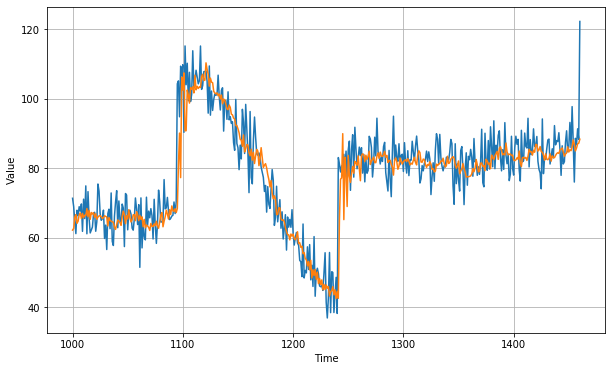

In [17]:
forecast = []
for time in range(len(series) - window_size):
  forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]


plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

y vemos que el error tuvo un bajón relativamente grande, so that's all folks!

In [18]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

4.829306